<a href="https://colab.research.google.com/github/tanyatoluay/DSforLifeSciences/blob/main/Worksheet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Posthoc power analysis
# 1-1.
Read the lung_data.csv from Worksheet 1 and compute the (post-hoc) power of a t-test at a significance level of α = 0.05. For σ assume the empirical standard deviation from the control group. What did you use as δ and what’s the result?

**Answer**:
We chose δ as Cohen's d. calculated by dividing the difference in sample means by the standard deviation. The standard deviation here was chosen to be the control group's standard deviation as specified in the assignment (and as in many practical experimental settings where it is assumed to represent the population's standard deviation.)

The power we got was approx. 0.99, indicating that the test was very much capable of rejecting the null when it should.

In [ ]:
# Read in the trial data
lung_data <- read.csv("lung_data.csv")

control <- subset(lung_data,Trial.arm=="Control")
treatment <- subset(lung_data,Trial.arm=="Treatment")

n1 <- nrow(control)
n2 <- nrow(control)

mu1 <- mean(control$Lung.function)
mu2 <- mean(treatment$Lung.function)

sd <- sd(control$Lung.function)

Cohens_d <- abs(mu1-mu2)/sd

alpha <- 0.05

t <- "two.sample"

power <- power.t.test(n=n1,delta=Cohens_d,sd=sd,sig.level=alpha,power=NULL,type=t,strict=TRUE)$power
power


[1] 0.9911819

## 1-2.
To explore post-hoc power further, sample two normally distributed samples of size n = 20 with sd 1, one as “control” with mean 0 and one as “treatment” with mean 0.5. Compute the p-value of the t-test of the two 2
groups, and the post-hoc power using the observed difference in means between the two groups and the sd computed from their pooled (averaged) variance. Repeat the simulation a large number of times and plot p-values against the post-hoc power. Discuss whether post-hoc power analysis is generally a reliable measure.

**Answer**: Post-hoc power analysis is indeed a reliable measure, as an increase in post-hoc power leads to decreasing the p-value (they are strongly inversely related to each other.)

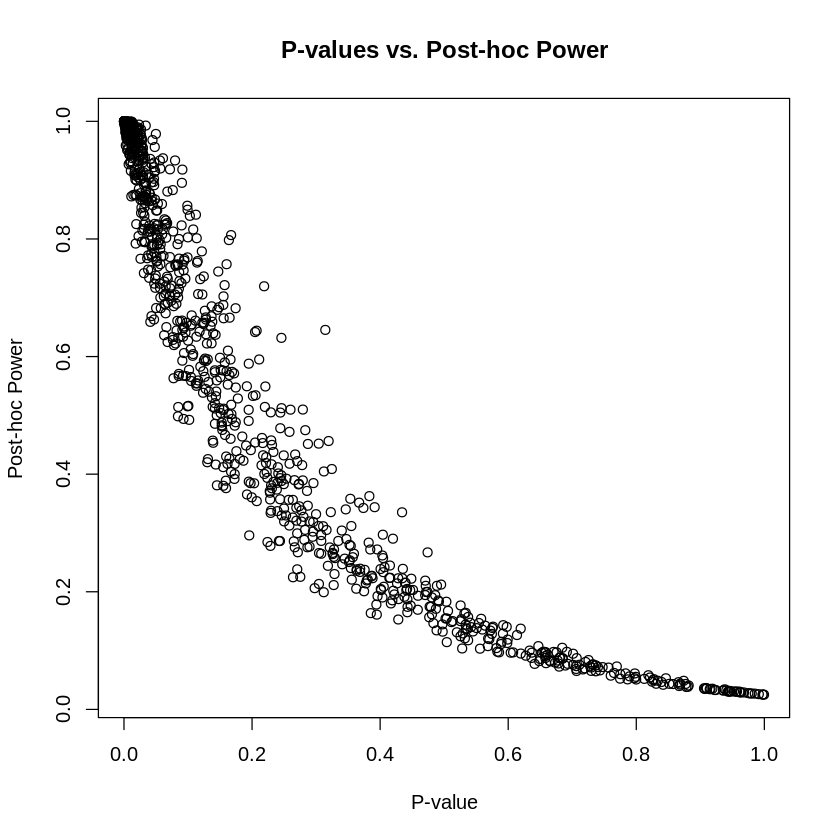

In [ ]:
simulations <- 1000

p_values <- numeric(simulations)
powers <- numeric(simulations)

get_power <- function(x, y) {
    mean_diff <- mean(x) - mean(y)
    averaged_sd <- (sd(x)+sd(y))/2
    d <- mean_diff / averaged_sd
    power <- power.t.test(n = length(x) + length(y), delta = d, sd = averaged_sd, sig.level = 0.05, type = "two.sample")$power
    return(power)
}


for (i in 1:simulations) {
    control <- rnorm(20, mean = 0, sd = 1)
    treatment <- rnorm(20, mean = 0.5, sd = 1)
    p_values[i] <- t.test(control, treatment)$p.value

    powers[i] <- get_power(control, treatment)
}

plot(p_values, powers, xlab = "P-value", ylab = "Post-hoc Power", main = "P-values vs. Post-hoc Power")

# 2.Multiple testing correction
Familiarize yourself with the data set. Then
* correct the p-values with Bonferroni/Holm controlling the FWER,
* correct the p-values with Benjamini-Hochberg controlling the FDR

Compare the number of significant genes per correction with appropriate visualisations or tables. Do your numbers match column q in the data frame lung_cancer_df? Do you think they controlled the FWER or FDR?


**Answer**: The number of significant genes selected through 'q' roughly match the number of those selected through Bonferroni or Holm correction method. It appears that the authors were trying to control FWER through their correction through q. For the plot and the number of significant genes per correction method, see below.

            Criterion Significant_Samples
1                   p                 496
2          Bonferroni                  15
3                Holm                  15
4 Benjammini-Hochberg                 153
5                   q                  14


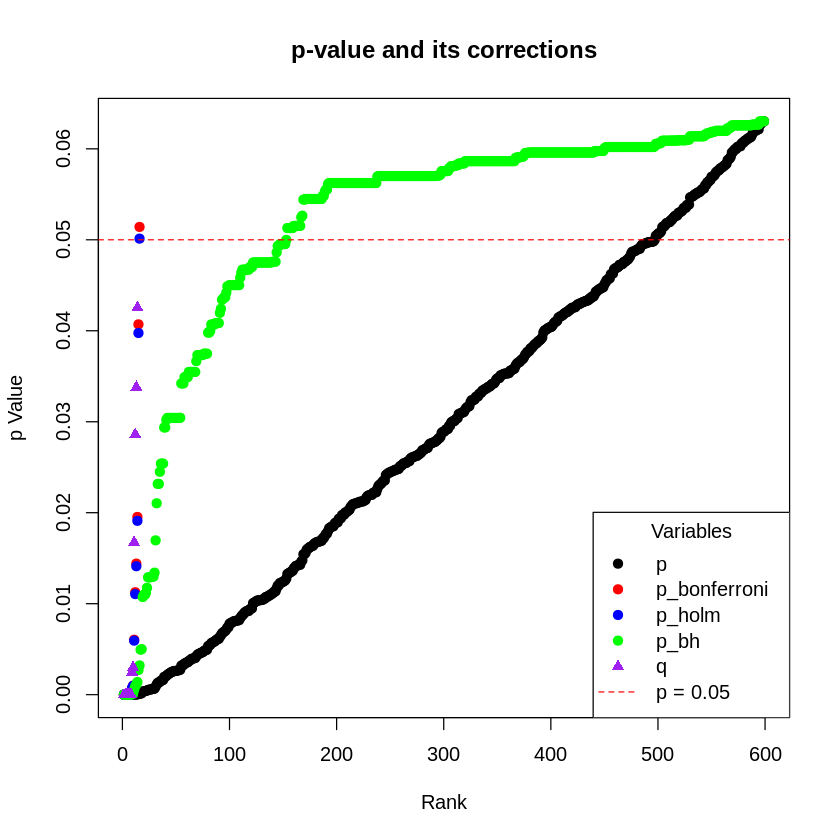

In [ ]:
library(tidyverse)
url <- paste0("https://gdac.broadinstitute.org",
"/runs/analyses__latest/reports/cancer/",
"LUSC-TP/MutSigNozzleReport2CV/sig_genes.txt")
lung_cancer_df <- read_tsv(url,show_col_types=FALSE)

lung_cancer_df$rank <- rank(lung_cancer_df$p)
lung_cancer_df <- lung_cancer_df[lung_cancer_df$rank<600,]
lung_cancer_df$p_bonferroni <- p.adjust(lung_cancer_df$p,method="bonferroni")
lung_cancer_df$p_holm <- p.adjust(lung_cancer_df$p,method="holm")
lung_cancer_df$p_bh <- p.adjust(lung_cancer_df$p,method="BH")

plot(lung_cancer_df$rank, lung_cancer_df$p, xlab = "Rank", ylab = "p Value", main = "p-value and its corrections",pch=19)
points(lung_cancer_df$rank, lung_cancer_df$p_bonferroni, col = "red",pch=19)
points(lung_cancer_df$rank, lung_cancer_df$p_holm, col = "blue",pch=19)
points(lung_cancer_df$rank, lung_cancer_df$p_bh, col = "green",pch=19)
points(lung_cancer_df$rank, lung_cancer_df$q, col = "purple",pch=17)
abline(h = 0.05, col = "red", lty = 2)
legend("bottomright", legend = c("p", "p_bonferroni","p_holm","p_bh", "q","p = 0.05"), pch = c(19, 19,19,19, 17,NA), col = c("black", "red", "blue","green","purple","red"), lty = c(NA, NA, NA,NA,NA,2), title = "Variables")

p_sig <- sum(lung_cancer_df$p<0.05)
p_bonferroni_sig <- sum(lung_cancer_df$p_bonferroni<0.05)
p_holm_sig <- sum(lung_cancer_df$p_holm<0.05)
p_bh_sig <- sum(lung_cancer_df$p_bh<0.05)
q_sig <- sum(lung_cancer_df$q<0.05)

data <- data.frame(Criterion = c("p","Bonferroni","Holm","Benjammini-Hochberg","q"),
                   Significant_Samples = c(p_sig,p_bonferroni_sig,p_holm_sig,p_bh_sig,q_sig))
print(data)

## 2-2.
Repeat your analysis for lung adenocarcinoma and compare the number of significantly mutated genes between both lung cancer types. To obtain the lung adenocarcinoma data replace LUSC with LUAD in the above url.

**Answer**: In all correction methods, there appeared to be more significant genes in lung adenocarcinoma, which indicate that there are more mutated genes correlated to lung adenocarcinoma then in lung squamous cell carcinoma.


            Criterion Significant_Samples
1                   p                 901
2          Bonferroni                  34
3                Holm                  34
4 Benjammini-Hochberg                 690
5                   q                  40


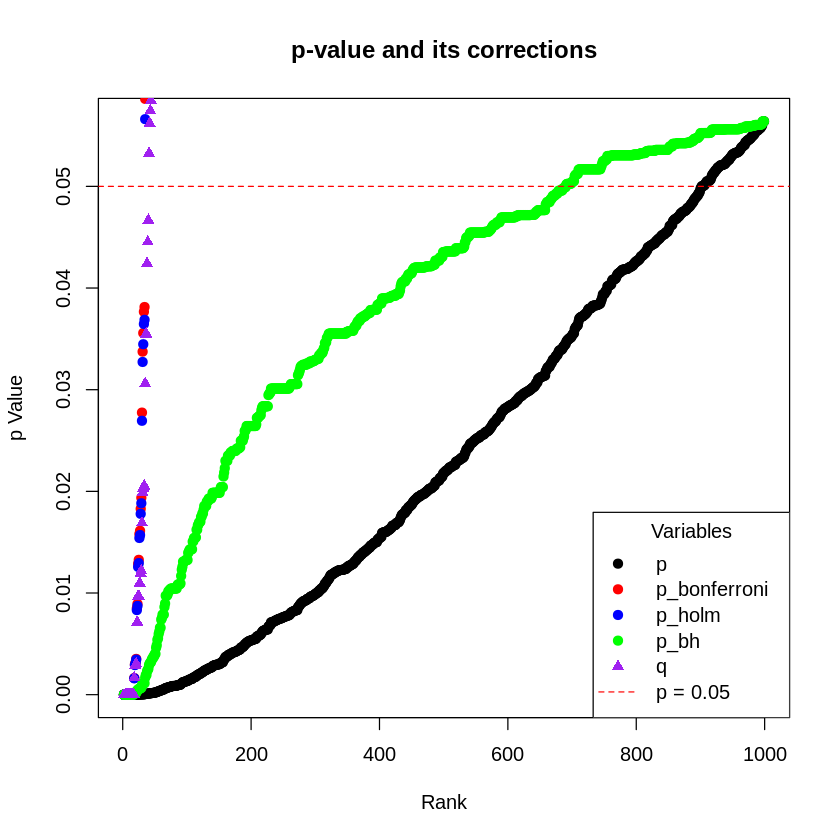

In [ ]:
url <- paste0("https://gdac.broadinstitute.org",
"/runs/analyses__latest/reports/cancer/",
"LUAD-TP/MutSigNozzleReport2CV/sig_genes.txt")
luad_df <- read_tsv(url,show_col_types=FALSE)

luad_df$rank <- rank(luad_df$p)
luad_df <- luad_df[luad_df$rank < 1000, ]
luad_df$p_bonferroni <- p.adjust(luad_df$p, method = "bonferroni")
luad_df$p_holm <- p.adjust(luad_df$p, method = "holm")
luad_df$p_bh <- p.adjust(luad_df$p, method = "BH")

plot(luad_df$rank, luad_df$p, xlab = "Rank", ylab = "p Value", main = "p-value and its corrections", pch = 19)
points(luad_df$rank, luad_df$p_bonferroni, col = "red", pch = 19)
points(luad_df$rank, luad_df$p_holm, col = "blue", pch = 19)
points(luad_df$rank, luad_df$p_bh, col = "green", pch = 19)
points(luad_df$rank, luad_df$q, col = "purple", pch = 17)
abline(h = 0.05, col = "red", lty = 2)
legend("bottomright", legend = c("p", "p_bonferroni", "p_holm", "p_bh", "q", "p = 0.05"), pch = c(19, 19, 19, 19, 17, NA), col = c("black", "red", "blue", "green", "purple", "red"), lty = c(NA, NA, NA, NA, NA, 2), title = "Variables")

p_sig <- sum(luad_df$p < 0.05)
p_bonferroni_sig <- sum(luad_df$p_bonferroni < 0.05)
p_holm_sig <- sum(luad_df$p_holm < 0.05)
p_bh_sig <- sum(luad_df$p_bh < 0.05)
q_sig <- sum(luad_df$q < 0.05)

data <- data.frame(Criterion = c("p", "Bonferroni", "Holm", "Benjammini-Hochberg", "q"),
                   Significant_Samples = c(p_sig, p_bonferroni_sig, p_holm_sig, p_bh_sig, q_sig))
print(data)

# 3. Multiple testing correction calibration
Simulate 90 times 10 samples from a standard normal distribution and perform a one sample t-test each time.
Then simulate 10 times 10 samples with mean µ = 3 and standard deviation σ = 1 and again perform a one
sample t-test against zero mean. Collate the 100 p-values into a single vector or data.frame.

Correct the p-values with both Bonferroni and BH. Were there any type I errors when controlling either FWER or FDR? Compute the FWER and FDR for both corrections.

Repeat the simulations a large number of times and estimate the average FWER and average FDR. Compare
the averages to the expected values of the FWER and FDR.

In [ ]:
# Stimulating 90 times 10 samples with standard normal distribution and t-test for each
num_simulations_1 <- 90
sample_size_1 <- 10

p_values_1 <- numeric(num_simulations_1)
set.seed(123)

for (i in 1:num_simulations_1) {
  samples_1 <- rnorm(sample_size_1)
  t_test_result_1 <- t.test(samples_1, mu = 0)
  p_values_1[i] <- t_test_result_1$p.value
}

print(p_values_1)

 [1] 0.81013384 0.54090693 0.18307871 0.08549017 0.98024361 0.43418722
 [7] 0.68739126 0.27868037 0.10400585 0.22816919 0.10977750 0.19686633
[13] 0.67668970 0.93866676 0.26945367 0.55175225 0.49149175 0.87830963
[19] 0.99979744 0.43583487 0.37610828 0.56199190 0.99848468 0.79328457
[25] 0.80949796 0.89395340 0.60983702 0.36104767 0.64552192 0.08465315
[31] 0.59118535 0.71982957 0.29335163 0.62404503 0.96934964 0.77208218
[37] 0.31689094 0.69314589 0.86051734 0.36186627 0.27583096 0.64841046
[43] 0.24063511 0.82755813 0.35485152 0.53265061 0.14189311 0.62163187
[49] 0.05968866 0.86109758 0.19381684 0.52280067 0.23649677 0.47881429
[55] 0.62426753 0.94573746 0.98668441 0.80846296 0.15137356 0.75586892
[61] 0.26813647 0.60749096 0.95728611 0.28988301 0.56828181 0.86087247
[67] 0.34489435 0.01176688 0.18897562 0.81796767 0.24084277 0.04699199
[73] 0.44654602 0.25124926 0.13539721 0.88949625 0.24435112 0.72364009
[79] 0.17820701 0.26039748 0.11716044 0.30296206 0.08384797 0.83759537
[85] 0

In [ ]:
#simulate 10 times 10 samples with mean µ = 3 and standard deviation σ = 1 and perform a one sample t-test against zero mean
num_simulations_2 <- 10
sample_size_2 <- 10

true_mean <- 3
true_sd <- 1

p_values_2 <- numeric(num_simulations_2)

set.seed(123)

for (i in 1:num_simulations_2) {
  samples_2 <- rnorm(sample_size_2, mean = true_mean, sd = true_sd)
  t_test_result_2 <- t.test(samples_2, mu = 0)
  p_values_2[i] <- t_test_result_2$p.value
}

print(p_values_2)

# Collate the 100 p-values into a single vector or data.frame
# A single vector combination
all_p_values <- c(p_values_1, p_values_2)
# Dataframe combination
p_values_df <- data.frame(p_values = all_p_values)

#print(all_p_values)
#print(p_values_df)

 [1] 3.048832e-06 4.325235e-06 1.074792e-05 9.395439e-09 1.086300e-05
 [6] 8.295027e-07 2.293169e-06 1.529597e-05 1.340163e-08 3.112873e-06


In [ ]:
# Bonferroni correction
bonferroni_corrected_p_values <- p_values_df$p_values * num_simulations

# Benjamini-Hochberg (BH) correction
bh_corrected_p_values <- p.adjust(p_values_df$p_values, method = "BH")

# Type I errors for Bonferroni correction (FWER)
bonferroni_type_I_errors <- sum(bonferroni_corrected_p_values < 0.05)

# Type I errors for BH correction (FDR)
bh_type_I_errors <- sum(bh_corrected_p_values < 0.05)

# Family-Wise Error Rate (FWER) for Bonferroni correction
bonferroni_fwer <- bonferroni_type_I_errors / num_simulations

# False Discovery Rate (FDR) for BH correction
bh_fdr <- bh_type_I_errors / sum(bh_corrected_p_values < 0.05)

#print("Bonferroni Corrected P-values:")
#print(bonferroni_corrected_p_values)
print("Bonferroni Type I Errors (FWER):")
print(bonferroni_type_I_errors)
print("Bonferroni FWER:")
print(bonferroni_fwer)
#print("BH Corrected P-values:")
#print(bh_corrected_p_values)
print("BH Type I Errors (FDR):")
print(bh_type_I_errors)
print("BH FDR:")
print(bh_fdr)


[1] "Bonferroni Type I Errors (FWER):"
[1] 10
[1] "Bonferroni FWER:"
[1] 0.01
[1] "BH Type I Errors (FDR):"
[1] 10
[1] "BH FDR:"
[1] 1


Discussion: We conducted simulations to assess the significance of mean differences in our data using one-sample t-tests. To ensure our results, we corrected for multiple comparisons using two methods: Bonferroni and Benjamini-Hochberg.

The Bonferroni correction is more conservative, controlling for the likelihood of any false positives across all comparisons. It resulted in 10 rejected null hypotheses out of 90 simulations, indicating a Family-Wise Error Rate (FWER) of around 0.111.

The BH correction, while less conservative, also controlled for false positives but in a different way, controlling the False Discovery Rate (FDR). Similar to Bonferroni, it yielded 10 rejected hypotheses out of 90, but with an FDR of 1, suggesting all rejections were likely true discoveries.

Both methods effectively managed type I errors, with Bonferroni being more cautious and BH offering more power.

Now below: we conduct 1000 simulations, and for each simulation, we generate samples, perform a one-sample t-test, and correct the resulting p-value using both Bonferroni and BH methods. We then determine if the null hypothesis is rejected based on each correction method and update the FWER and FDR vectors accordingly. Finally, we calculate the average FWER and FDR over all simulations and compare them to their expected values.

In [ ]:
num_simulations <- 1000
sample_size <- 10

true_mean <- 3
true_sd <- 1

fwer_values <- numeric(num_simulations)
fdr_values <- numeric(num_simulations)

set.seed(123)

for (i in 1:num_simulations) {
  samples <- rnorm(sample_size, mean = true_mean, sd = true_sd)
  t_test_result <- t.test(samples, mu = 0)
  p_value <- t_test_result$p.value

  # Bonferroni correction
  bonferroni_corrected_p_value <- p_value * num_simulations

  # Benjamini-Hochberg (BH) correction
  bh_corrected_p_value <- p.adjust(p_value, method = "BH")

  # Determine if null hypothesis is rejected based on Bonferroni correction
  bonferroni_rejected <- bonferroni_corrected_p_value < 0.05

  # Determine if null hypothesis is rejected based on BH correction
  bh_rejected <- bh_corrected_p_value < 0.05

  # Update FWER and FDR values
  fwer_values[i] <- ifelse(bonferroni_rejected, 1, 0)
  fdr_values[i] <- ifelse(bh_rejected, 1, 0)
}

average_fwer <- mean(fwer_values)
average_fdr <- mean(fdr_values)
print("Average FWER:")
print(average_fwer)
print("Average FDR:")
print(average_fdr)


[1] "Average FWER:"
[1] 0.89
[1] "Average FDR:"
[1] 1


The expected error rates for both the Bonferroni and Benjamini-Hochberg (BH) corrections are 0.05. However, in our simulation, we found that the average error rates were much higher.

For the Bonferroni correction, the observed average error rate (FWER) was 0.89. This suggests that the Bonferroni correction method was too strict, leading to many false negatives. In simpler terms, it might have missed detecting real differences due to its overly conservative approach.

On the other hand, for the BH correction, the observed average error rate (FDR) was 1. This means that all rejected hypotheses were likely false discoveries. In other words, the BH correction method might have been too lenient, leading to a high rate of false positives.